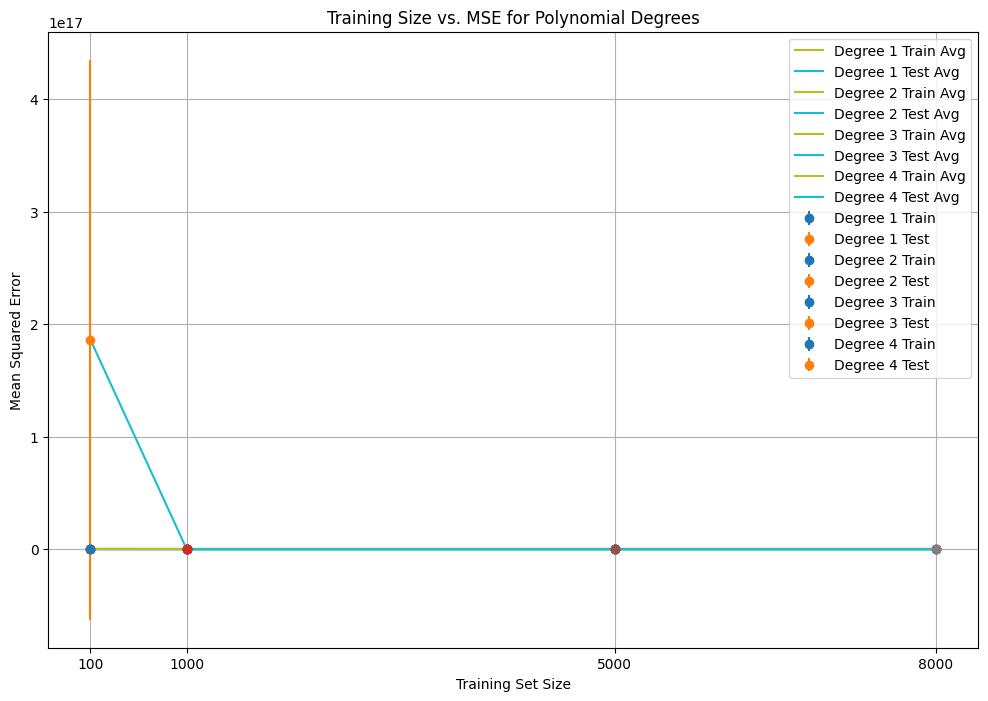

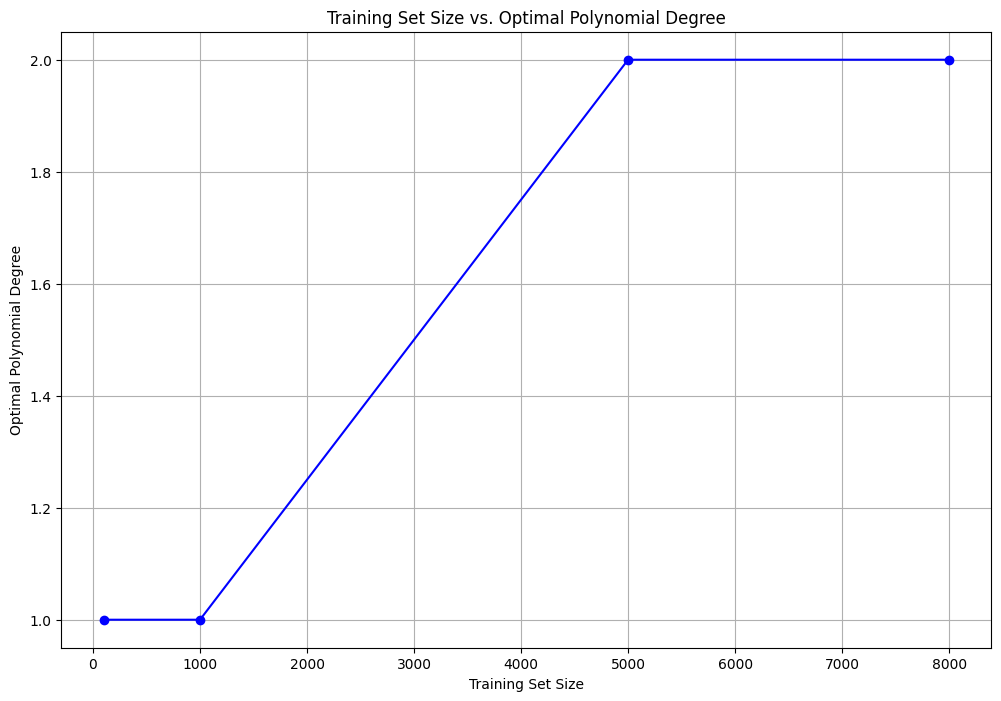

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the dataset
file_path = "online_shoppers_intention.csv"
data = pd.read_csv(file_path)

# Select features and target variable
features = [
    "Administrative_Duration",
    "Informational_Duration",
    "ProductRelated_Duration",
    "BounceRates",
    "ExitRates",
    "SpecialDay",
]
target = "PageValues"

X = data[features]
y = data[target]

# Split into training and test sets (80%:20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Function to generate random subsets and train models
def train_and_evaluate(X_train, y_train, X_test, y_test, subset_sizes, degrees, num_sets=40):
    results = {size: {degree: [] for degree in degrees} for size in subset_sizes}

    for size in subset_sizes:
        for _ in range(num_sets):
            # Randomly sample the subset
            indices = np.random.choice(len(X_train), size, replace=False)
            X_subset = X_train.iloc[indices]
            y_subset = y_train.iloc[indices]

            for degree in degrees:
                # Transform features for the polynomial degree
                poly = PolynomialFeatures(degree)
                X_poly = poly.fit_transform(X_subset)
                X_test_poly = poly.transform(X_test)

                # Train the model
                model = LinearRegression()
                model.fit(X_poly, y_subset)

                # Evaluate on training and test sets
                train_pred = model.predict(X_poly)
                test_pred = model.predict(X_test_poly)

                train_mse = mean_squared_error(y_subset, train_pred)
                test_mse = mean_squared_error(y_test, test_pred)

                # Store results
                results[size][degree].append((train_mse, test_mse))

    return results

# Step 3: Define subset sizes and polynomial degrees
subset_sizes = [100, 1000, 5000, 8000]
degrees = [1, 2, 3, 4]

# Train models and collect results
results = train_and_evaluate(X_train, y_train, X_test, y_test, subset_sizes, degrees)

# Step 4: 
# Find optimal polynomial degree for each subset size
def find_optimal_degree(results):
    optimal_degrees = {}
    
    for size in subset_sizes:
        avg_mse = {degree: np.mean(results[size][degree]) for degree in degrees}
        optimal_degree = min(avg_mse, key=avg_mse.get)  # Degree with minimum MSE
        optimal_degrees[size] = optimal_degree
    
    return optimal_degrees

# Analyzing the MSE vs training set size for different polynomial degrees
def plot_results(results):
    plt.figure(figsize=(12, 8))

    for degree in degrees:
        avg_train_errors = []
        avg_test_errors = []

        for size in subset_sizes:
            train_errors = [res[0] for res in results[size][degree]]
            test_errors = [res[1] for res in results[size][degree]]

            avg_train_errors.append(np.mean(train_errors))
            avg_test_errors.append(np.mean(test_errors))

            # Confidence intervals (95%)
            train_conf = 1.96 * np.std(train_errors) / np.sqrt(len(train_errors))
            test_conf = 1.96 * np.std(test_errors) / np.sqrt(len(test_errors))

            # Plot confidence intervals
            plt.errorbar(
                size,
                np.mean(train_errors),
                yerr=train_conf,
                fmt="o",
                label=f"Degree {degree} Train" if size == subset_sizes[0] else "",
            )
            plt.errorbar(
                size,
                np.mean(test_errors),
                yerr=test_conf,
                fmt="o",
                label=f"Degree {degree} Test" if size == subset_sizes[0] else "",
            )

        # Plot average errors
        plt.plot(subset_sizes, avg_train_errors, label=f"Degree {degree} Train Avg")
        plt.plot(subset_sizes, avg_test_errors, label=f"Degree {degree} Test Avg")

    plt.xscale("linear")  # Change to linear scale
    plt.xticks(subset_sizes)  # Ensure the x-ticks are the subset sizes
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.title("Training Size vs. MSE for Polynomial Degrees")
    plt.legend()
    plt.grid()
    plt.show()


def plot_optimal_capacity(optimal_degrees):
    plt.figure(figsize=(12, 8))

    sizes = list(optimal_degrees.keys())
    optimal_vals = list(optimal_degrees.values())
    
    # Plot the relationship between training set size and optimal degree
    plt.plot(sizes, optimal_vals, marker='o', linestyle='-', color='b')
    
    plt.xlabel("Training Set Size")
    plt.ylabel("Optimal Polynomial Degree")
    plt.title("Training Set Size vs. Optimal Polynomial Degree")
    plt.grid()
    plt.show()

# Get the optimal polynomial degrees for each subset size
optimal_degrees = find_optimal_degree(results)


# Plot the results
plot_results(results)

# Plot the graph of training size vs. optimal polynomial degree
plot_optimal_capacity(optimal_degrees)